In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

In [ ]:
data,info=tfds.load(name="malaria",shuffle_files=True,as_supervised=True,with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete4KPHJU/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
! wget -O dog_1.jpg https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg
! wget -O dog_2.jpg https://cdn.britannica.com/26/187226-050-E1A266DB/dog-package-German-Shepherd-explosives-drugs.jpg

--2023-06-21 06:45:19--  https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 13.249.85.15, 13.249.85.122, 13.249.85.13, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|13.249.85.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344524 (336K) [image/jpeg]
Saving to: ‘dog_1.jpg’

dog_1.jpg           100%[===================>] 336.45K  --.-KB/s    in 0.05s   

2023-06-21 06:45:20 (6.60 MB/s) - ‘dog_1.jpg’ saved [344524/344524]

--2023-06-21 06:45:20--  https://cdn.britannica.com/26/187226-050-E1A266DB/dog-package-German-Shepherd-explosives-drugs.jpg
Resolving cdn.britannica.com (cdn.britannica.com)... 13.249.85.15, 13.249.85.122, 13.249.85.13, ...
Connecting to cdn.britannica.com (cdn.britannica.com)|13.249.85.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 157366 (154K) [image/jpeg]
Saving to: ‘dog_2.jpg’

dog_2.jpg           100%[=========

In [ ]:
TRAIN_RATIO=0.5
TEST_RATIO=0.1
VAL_RATIO=0.1
data=data["train"]
DATA_SIZE=len(data)
train_data=data.take(int(TRAIN_RATIO*DATA_SIZE))
test_val_data=data.skip(int(TRAIN_RATIO*DATA_SIZE))
test_data=test_val_data.take(int(TEST_RATIO*DATA_SIZE))
val_data=test_val_data.skip(int(TRAIN_RATIO*DATA_SIZE)-int(TEST_RATIO*DATA_SIZE))
val_data=val_data.take(int(VAL_RATIO*DATA_SIZE))

In [ ]:
train_data

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
IMAGE_SIZE=(224,224)
def resize_rescaling(img,lab):
  print(img.shape)
  return tf.image.resize(img,IMAGE_SIZE)/255.,lab

In [ ]:
### to add dropout layers and to initialize L2 regluarlize

dropout_rate=0.2
model=tf.keras.Sequential(
    [
        tf.keras.Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3)),

        tf.keras.layers.Conv2D(8,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(rate=dropout_rate),

        tf.keras.layers.Conv2D(16,3,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(8,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid"),
    ]
)

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
metrics=[
    tf.keras.metrics.FalseNegatives(name="fn"),
    "accuracy"
]
loss=tf.keras.losses.BinaryCrossentropy()

### **Data Augmentation**

In [ ]:
## first way using map method

def augmentation(img,lab):
  img,lab=resize_rescaling(img,lab)
  img=tf.image.rot90(img)
  # img=tf.image.central_crop(img,0.5)
  return img,lab

In [ ]:
train_data=train_data.shuffle(buffer_size=1000).map(augmentation).batch(32).prefetch(tf.data.AUTOTUNE)
val_data=val_data.shuffle(buffer_size=1000).map(augmentation).batch(32).prefetch(tf.data.AUTOTUNE)
test_data=test_data.map(resize_rescaling)

In [ ]:
def visualiz_data(data):
  for img,lab in data.take(2):
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title(lab)
    plt.show()

In [ ]:
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
model.fit(train_data,epochs=2,validation_data=val_data)

Epoch 1/2
431/431 [==============================] - 57s 96ms/step - loss: 0.7504 - fn: 4082.0000 - accuracy: 0.5011 - val_loss: 0.6936 - val_fn: 0.0000e+00 - val_accuracy: 0.4958
Epoch 2/2
431/431 [==============================] - 43s 100ms/step - loss: 0.6933 - fn: 3966.0000 - accuracy: 0.5029 - val_loss: 0.6933 - val_fn: 0.0000e+00 - val_accuracy: 0.4962


In [ ]:
## dataa augmentation using layers

### to add dropout layers and to initialize L2 regluarlize

dropout_rate=0.2
model=tf.keras.Sequential(
    [
        tf.keras.Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3)),

        tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.Conv2D(8,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.Dropout(rate=dropout_rate),

        tf.keras.layers.Conv2D(16,3,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(8,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid"),
    ]
)
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
model.fit(train_data,epochs=2,validation_data=val_data)

Epoch 1/2
431/431 [==============================] - 49s 104ms/step - loss: 0.9147 - fn: 4221.0000 - accuracy: 0.5011 - val_loss: 0.7082 - val_fn: 0.0000e+00 - val_accuracy: 0.4944
Epoch 2/2
431/431 [==============================] - 41s 93ms/step - loss: 0.6976 - fn: 3395.0000 - accuracy: 0.4955 - val_loss: 0.6936 - val_fn: 0.0000e+00 - val_accuracy: 0.4947


In [ ]:
### another way to implement data augmentation
data_aug_model=tf.keras.Sequential(
      [
          # tf.keras.layers.RandomFlip(mode="horizontal")
          tf.keras.layers.RandomContrast(factor=0.4)
      ]
  )
def data_augement_layer(img,lab):
  # img=tf.image.resize(img,IMAGE_SIZE)
  return data_aug_model(img,training=False),lab


In [ ]:
train_data=train_data.map(data_augement_layer).batch(32)
val_data=val_data.map(data_augement_layer).batch(32)

In [ ]:
img=list(data["train"].take(1))[0][0]

In [ ]:
aug_img=data_augement_layer(img,1)

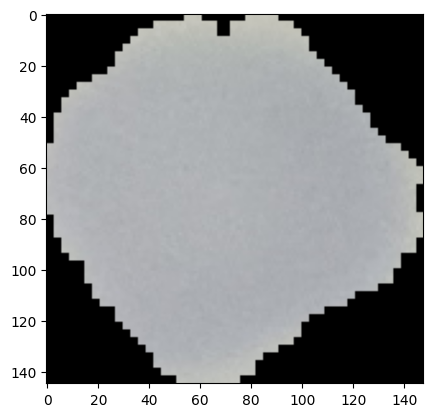

In [ ]:
plt.imshow(img)

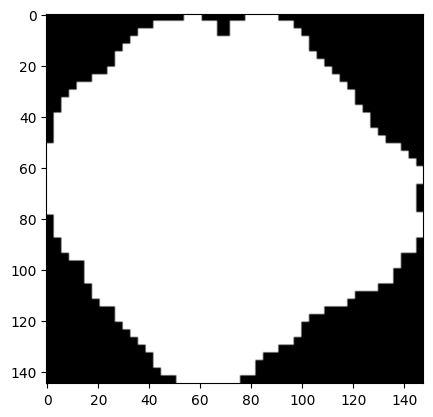

In [ ]:
plt.imshow(aug_img[0])

In [ ]:
### another way

resize_rescaling_model=tf.keras.Sequential(
    [
        tf.keras.layers.Resizing(224,224),
        tf.keras.layers.Rescaling(1./255.)
    ]
)

model=tf.keras.Sequential(
    [
        tf.keras.Input((None,None,3)),
        resize_rescaling_model,
        data_aug_model,

        tf.keras.layers.Conv2D(8,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(rate=dropout_rate),

        tf.keras.layers.Conv2D(16,3,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(8,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid"),
    ]
)


In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None))>

In [ ]:
train_data=train_data.batch(1)
val_data=val_data.batch(1)
model.compile(optimizer=optimizer,loss=loss,metrics=metrics)
model.fit(train_data,epochs=2,validation_data=val_data)

## mixup augmentation

In [ ]:
lam=tfp.distributions.Beta(0.2,0.2)
lam=lam.sample(1)
lam.numpy()[0]

0.9808297

In [ ]:
import tensorflow_probability as tfp
import cv2
@tf.function
def mix_up(data_1,data_2):
  (img_1,lab_1),(img_2,lab_2)=data_1,data_2
  lam_1=tfp.distributions.Beta(0.4,0.4)
  lam=lam_1.sample(1)[0]
  print(lam)
  # img_1=plt.imread(img_1)
  # img_2=plt.imread(img_2)
  # img_1=tf.image.resize(img_1,(224,224))
  # img_2=tf.image.resize(img_2,(224,224))

  new_image=lam*tf.cast(img_1,dtype=tf.float32)+(1-lam)*tf.cast(img_2,dtype=tf.float32)
  print(lam,lab_1,lab_2)
  new_label=lam*tf.cast(lab_1,dtype=tf.float32)+(1-lam)*tf.cast(lab_2,dtype=tf.float32)

  return new_image,new_label

In [ ]:

train_data_1=train_data.shuffle(buffer_size=1000,reshuffle_each_iteration=True).map(resize_rescaling)
train_data_2=train_data.shuffle(buffer_size=1000,reshuffle_each_iteration=True).map(resize_rescaling)

mix_data=tf.data.Dataset.zip((train_data_1,train_data_2))

(None, None, 3)
(None, None, 3)


In [ ]:
mix_data

<_ZipDataset element_spec=((TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)), (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None)))>

In [ ]:
train_data_mix=mix_data.shuffle(buffer_size=1000,reshuffle_each_iteration=True).map(mix_up).prefetch(tf.data.AUTOTUNE)

Tensor("strided_slice:0", shape=(), dtype=float32)
Tensor("strided_slice:0", shape=(), dtype=float32) Tensor("data_1_1:0", shape=(), dtype=int64) Tensor("data_2_1:0", shape=(), dtype=int64)


In [ ]:
train_data_mix=train_data_mix.batch(16)

In [ ]:
train_data_mix

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [ ]:
# from google.colab.patches import cv2_imshow
# cv2_imshow(new_image.numpy()
# )

In [ ]:
img,lab=list(train_data_mix.take(1))[0]

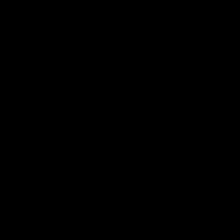

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(img[2].numpy()
)

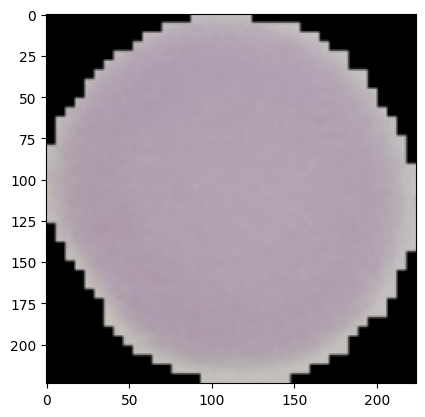

In [ ]:
plt.imshow(img[0])

In [ ]:
### to add dropout layers and to initialize L2 regluarlize
IMAGE_SIZE=(224,224)
dropout_rate=0.2
model=tf.keras.Sequential(
    [
        tf.keras.Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3)),

        tf.keras.layers.Conv2D(8,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(rate=dropout_rate),

        tf.keras.layers.Conv2D(16,3,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(8,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid"),
    ]
)

In [ ]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
metrics=[
    tf.keras.metrics.FalseNegatives(name="fn"),
    "accuracy"
]
loss=tf.keras.losses.BinaryCrossentropy()

In [ ]:
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [ ]:
hist=model.fit(train_data_mix,epochs=1)

862/862 [==============================] - 46s 47ms/step - loss: 0.7668 - fn: 4499.0000 - accuracy: 0.2465


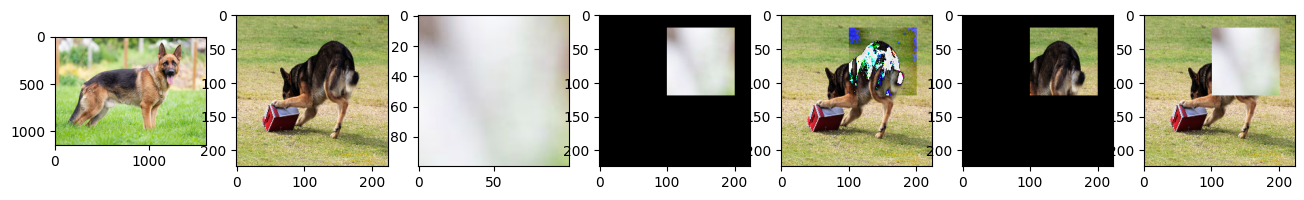

In [ ]:
plt.figure(figsize=(16,8))
img_1=plt.imread("dog_1.jpg")
img_2=cv2.resize(plt.imread("dog_2.jpg"),(224,224))
crop_img=tf.image.crop_to_bounding_box(img_1,20,100,100,100)
plt.subplot(1,7,1)
plt.imshow(img_1)
plt.subplot(1,7,2)
plt.imshow(img_2)
plt.subplot(1,7,3)
plt.imshow(crop_img)
fitted_img=tf.image.pad_to_bounding_box(crop_img,20,100,224,224)
plt.subplot(1,7,4)
plt.imshow(fitted_img)
combine_img=img_2+fitted_img
plt.subplot(1,7,5)
plt.imshow(combine_img)

crop_img_2=tf.image.crop_to_bounding_box(img_2,20,100,100,100)
fitted_img_2=tf.image.pad_to_bounding_box(crop_img_2,20,100,224,224)
plt.subplot(1,7,6)
plt.imshow(fitted_img_2)

fianl_img=img_2-fitted_img_2
fianl_img=fianl_img+fitted_img
plt.subplot(1,7,7)
plt.imshow(fianl_img)

In [ ]:
lam=tfp.distributions.Beta(0.2,0.2).sample(1)[0].numpy()
SEED=10

r_x=tf.cast(tfp.distributions.Uniform(0,224).sample(1,seed=SEED)[0],dtype=tf.int16)
r_y=tf.cast(tfp.distributions.Uniform(0,224).sample(1,seed=SEED)[0],dtype=tf.int16)

r_h=tf.cast(224*tf.math.sqrt(1-lam),dtype=tf.int16)
r_w=tf.cast(224*tf.math.sqrt(1-lam),dtype=tf.int16)

r_h=tf.clip_by_value(r_h-r_x//2,0,224)
r_w=tf.clip_by_value(r_w-r_x//2,0,224)

r_b_h=tf.clip_by_value(r_h+r_x//2,0,224)
r_b_w=tf.clip_by_value(r_w+r_x//2,0,224)

r_h=r_b_h-r_h
r_w=r_b_w-r_w

if r_h==0:
  r_h=1
if r_w==0:
  r_w=1


In [ ]:
r_h,r_w

In [ ]:
r_x,r_y

(<tf.Tensor: shape=(), dtype=int16, numpy=162>,
 <tf.Tensor: shape=(), dtype=int16, numpy=37>)

### Data Augmentation using Albumentation Lib

In [ ]:
!pip install -U albumentations -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 3.6 MB/s eta 0:00:00


In [ ]:
import albumentations as A

In [ ]:
from albumentations.augmentations.geometric.functional import rot90
transforms=A.Compose(
    [
        A.Resize(224,224),
        A.OneOf([
            A.HorizontalFlip(),
        A.VerticalFlip(p=0.5)],p=0.5),
        A.RandomGridShuffle(),
        A.Sharpen(p=0.2),
        A.Cutout(p=1.,num_holes=1,max_h_size=30,max_w_size=30,fill_value=255.)
    ]
)

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [ ]:
def alum_data_aug(image):
  data={"image":image}
  image=transforms(**data)
  image=image["image"]
  image=tf.cast(image/255.,tf.float32)
  return image

In [ ]:
def process_data(img,lab):
  aug_img=tf.numpy_function(alum_data_aug,inp=[img],Tout=tf.float32)
  return aug_img,lab

In [ ]:
img_1=plt.imread("dog_1.jpg")
out_img,lab=process_data(img_1,"dog")

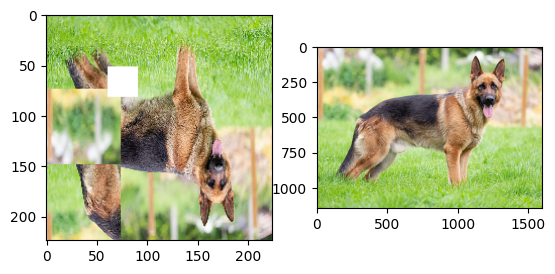

In [ ]:
plt.subplot(1,2,1)
plt.imshow(out_img)
plt.subplot(1,2,2)
plt.imshow(img_1)

In [ ]:
train_data=train_data.shuffle(buffer_size=1000).map(process_data).batch(16).prefetch(tf.data.AUTOTUNE)

In [ ]:
img,lab=list(train_data.take(1))[0]

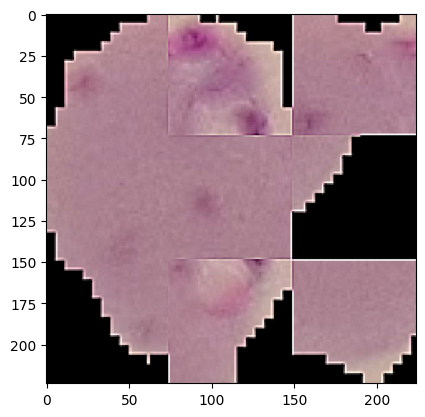

In [ ]:
plt.imshow(img[2])

### Custom Loss function

In [ ]:
tf.config.experimental_run_functions_eagerly(True)
@tf.function
def custom_bse(y_true,y_pred):
  bse=tf.keras.losses.BinaryCrossentropy()
  return bse(y_true,y_pred)

In [ ]:
model=tf.keras.Sequential(
    [
        tf.keras.Input((IMAGE_SIZE[0],IMAGE_SIZE[1],3)),

        tf.keras.layers.Conv2D(8,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Dropout(rate=dropout_rate),

        tf.keras.layers.Conv2D(16,3,activation="relu"),
        tf.keras.layers.MaxPool2D(2,2),
        tf.keras.layers.Conv2D(32,3,activation="relu",kernel_regularizer=tf.keras.regularizers.L2(0.1)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(16,activation="relu"),
        tf.keras.layers.Dropout(rate=dropout_rate),
        tf.keras.layers.Dense(8,activation="relu"),
        tf.keras.layers.Dense(1,activation="sigmoid"),
    ]
)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
from tensorflow.python.eager.context import eager_mode
model.compile(loss=custom_bse,metrics=["accuracy"],optimizer="adam")
model.fit(train_data,epochs=1)

 15/862 [..............................] - ETA: 6:05 - loss: 2.9957 - accuracy: 0.5167

KeyboardInterrupt: ignored